In [1]:
import kdsource as kds
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
Plano_1 = kds.surfsource.SurfaceSourceFile('neutrones.mcpl.gz')
df = Plano_1.get_pandas_dataframe()
W1 = df['x'].min()
W2 = df['x'].max()
H1 = df['y'].min()
H2 = df['y'].max()
print(W1,W2,H1,H2)

Number of particles in file neutrones.mcpl.gz: 63862
100% n, 0% g, 0% e-, 0% e+, 0% p, 


-6.409584045410156 6.407461166381836 -6.409070014953613 6.399759769439697


In [3]:
Plano_1.get_pandas_dataframe()['z'].min()

69.58892822265625

In [4]:
plano_w= Plano_1.Filter_Sourface_Source(domain={'w':[0,1]})
plano_w._df2['z'] = 69.5889
plano_w.save_source_file("neutrones_w.mcpl")


Saving into MCPL format
Saving into SSV format (ASCII)


Done, saved into temp.txt file
ssv_open_file: Opened file "temp.txt":
MCPL: Attempting to compress file neutrones_w.mcpl with gzip
MCPL: Succesfully compressed file into neutrones_w.mcpl.gz
Created neutrones_w.mcpl.gz
Done, saved into neutrones_w.mcpl file


In [7]:
E0 = plano_w.get_pandas_dataframe()['E'].max()

In [8]:
plist_1 = kds.PList("neutrones_w.mcpl.gz")
geometry_1 = kds.Geometry([kds.geom.Lethargy(E0=E0),kds.geom.SurfCircle(rho_max=6.409070014953613),kds.geom.Isotrop(keep_zdir=True)])
S_1 = kds.KDSource(plist_1,geometry_1)

Using existing file neutrones_w.mcpl.gz
sum_weights = 42981.58801576495
p2 = 36358.613684568096
N = 57248
N_eff = 50810.98317951159


In [9]:
var_importance = [5,1,1,10,1,1]
# var_importance = [1,1,1]

parts,ws = S_1.plist.get(N=-1)
scaling = S_1.geom.std(parts=parts)
scaling /= var_importance

# Number of particles to use for optimization.
# A large number (1E5 or more) gives better bandwidths, but takes longer to
# compute.
N = 1E5

S_1.bw_method = "silv"
S_1.fit(N, scaling=scaling)


Using 57248 particles for fit.
Calculating bw ... 
Done
Optimal bw (silv) = [[0.4598605  1.0116201  1.00107076 0.00700243 0.07002429 0.07002429]]


Using 57248 particles for fit.
Calculating bw ... 
Done
Optimal bw (silv) = [[0.4598605  1.0116201  1.00107076 0.00700243 0.07002429 0.07002429]]
Using 57248 particles for fit.
Calculating bw ... 
Using k = 10 neighbors per batch (batch_size = 10000)
Correction factor: f_k = k_float / k = 1.0
Effective total neighbors: K_eff = 57.248
batch = 1 / 6


batch = 2 / 6
batch = 3 / 6
batch = 4 / 6
batch = 5 / 6
batch = 6 / 6
Done
Optimal bw (knn) = [[1.01811737 2.2396966  2.21634067 0.01550317 0.15503167 0.15503167]
 [1.36989895 3.01356022 2.98213431 0.02085985 0.20859847 0.20859847]
 [0.99192461 2.18207667 2.15932161 0.01510432 0.15104322 0.15104322]
 ...
 [1.06117284 2.33441178 2.31006814 0.01615879 0.16158785 0.16158785]
 [4.47556976 9.845543   9.74287202 0.06815079 0.68150793 0.68150793]
 [3.46122425 7.6141439  7.53474233 0.05270506 0.52705061 0.52705061]]
Using 10000 particles for fit.
Calculating bw ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  2.1min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  3.2min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.5min finished


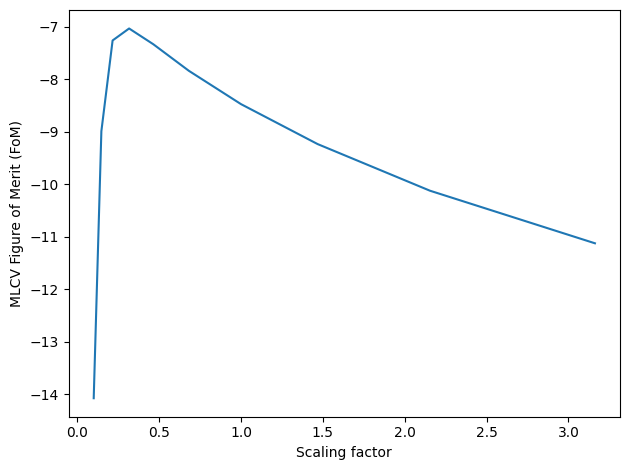

Done
Optimal bw (mlcv) = [[0.32195698 0.70825425 0.70086846 0.00490253 0.04902532 0.04902532]
 [0.43320008 0.95297142 0.94303367 0.00659646 0.06596463 0.06596463]
 [0.3136741  0.69003323 0.68283745 0.00477641 0.04776406 0.04776406]
 ...
 [1.11436632 2.451429   2.42586509 0.01696878 0.16968778 0.16968778]
 [0.95598998 2.1030262  2.08109549 0.01455714 0.14557135 0.14557135]
 [0.42406422 0.93287397 0.9231458  0.00645735 0.06457348 0.06457348]]
Using 57248 particles for fit.


In [10]:
S_1.bw_method = "silv"
S_1.fit(N, scaling=scaling)

# Method 3: Adaptive Maximum Likelihood Cross-Validation:
# Creates a grid of adaptive bandwidths and evaluates the
# cross-validation scores on each one, which is an indicator of the
# quality of the estimation. Selects the bandwidth that optimizes
# CV score.
# kNN is used to generate the seed adaptive bandwidth.

# kNN bandwidth
S_1.bw_method = "knn"
batch_size = 10000 # Batch size for KNN search
k = 10             # Numer of neighbors per batch
S_1.fit(N, scaling=scaling, batch_size=batch_size, k=k)
bw_knn = S_1.kde.bw

# MLCV optimization of previously calculated kNN bandwidth
S_1.bw_method = "mlcv"
N_cv = int(1E4)   # Use a smaller N to reduce computation times
seed = bw_knn[:N_cv] # Use kNN BW as seed (first N elements)
grid = np.logspace(-1,0.5,10)
S_1.fit(N_cv, scaling=scaling, seed=seed, grid=grid)
bw_cv = S_1.kde.bw

# Extend MLCV optimization to full KNN BW
bw_knn_cv = bw_knn * bw_cv[0]/bw_knn[0] # Apply MLCV factor
dim = S_1.geom.dim
bw_knn_cv *= kds.bw_silv(dim,len(bw_knn))/kds.bw_silv(dim,len(bw_cv)) # Apply Silverman factor
S_1 = kds.KDSource(plist_1, geometry_1, bw=bw_knn_cv) # Create new KDSource with full BW
S_1.fit(N=N, scaling=scaling)

In [11]:
xmlfile = "Source_1.xml"

S_1.save(xmlfile)


Bandwidth file: neutrones_w_bws
Successfully saved parameters file Source_1.xml


'Source_1.xml'

In [12]:
N_resampled = 1E4
!kdtool resample "$xmlfile" -o "resampled_neutrones" -n $N_resampled
resampled = "resampled_neutrones.mcpl.gz"

Reading xmlfile Source_1.xml...
Done.
Resampling...
MCPL: Attempting to compress file resampled_neutrones.mcpl with gzip
MCPL: Succesfully compressed file into resampled_neutrones.mcpl.gz
Successfully sampled 10000 particles.


In [13]:
resampled = "resampled_neutrones.mcpl.gz"
#SEPARO POR PLANOS
Plano_resampled_1 = kds.surfsource.SurfaceSourceFile(resampled)
Plano_resampled_1.Source_factor(Plano_1,update=True)

Number of particles in file resampled_neutrones.mcpl.gz: 10000
100% n, 0% g, 0% e-, 0% e+, 0% p, 


4.736411233749986

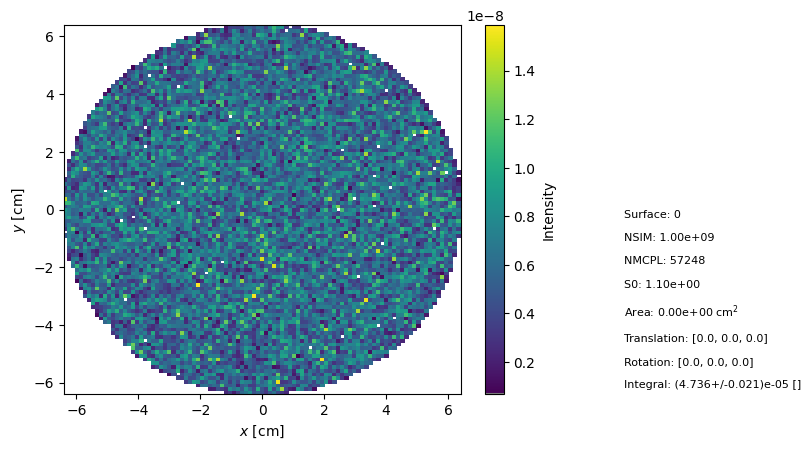

In [14]:
plano_w.plot_distribution(vars=['x','y'],bins=[100,100], scales=['linear','linear'], norm_vars=[], info=True, zscale='linear')


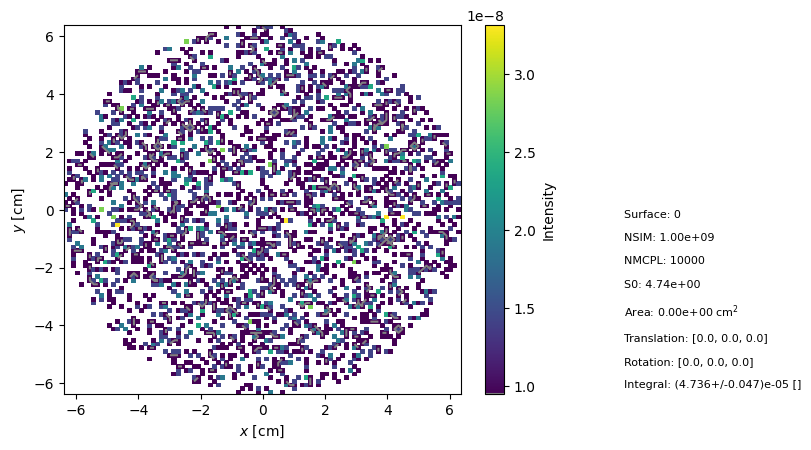

In [15]:
Plano_resampled_1.plot_distribution(vars=['x','y'],bins=[100,100], scales=['linear','linear'], norm_vars=[], info=True, zscale='linear')


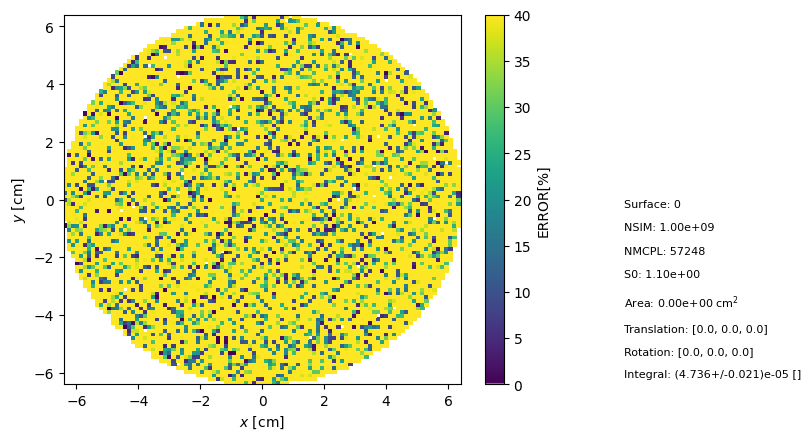

In [16]:
plano_w.plot_distribution(vars=['x','y'],bins=[100,100], scales=['linear','linear'], norm_vars=[], info=True, zlabel='ERROR[%]',vmin=0,vmax=40,plot_difference=True, Difference_to=Plano_resampled_1)


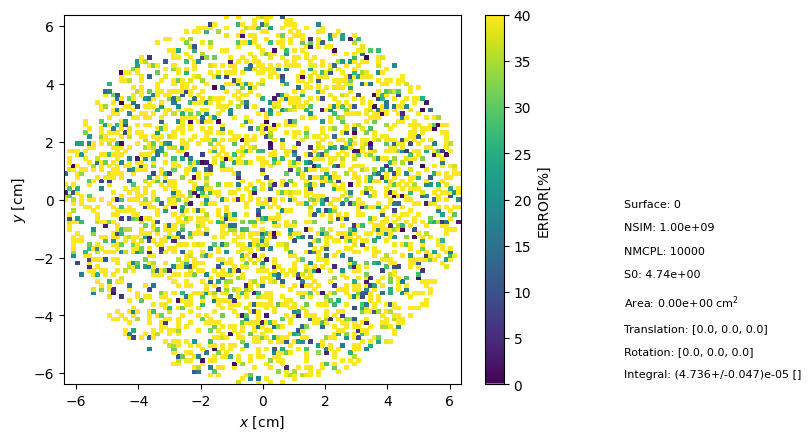

In [17]:
Plano_resampled_1.plot_distribution(vars=['x','y'],bins=[100,100], scales=['linear','linear'], norm_vars=[], info=True, zlabel='ERROR[%]',vmin=0,vmax=40,plot_difference=True, Difference_to=plano_w)


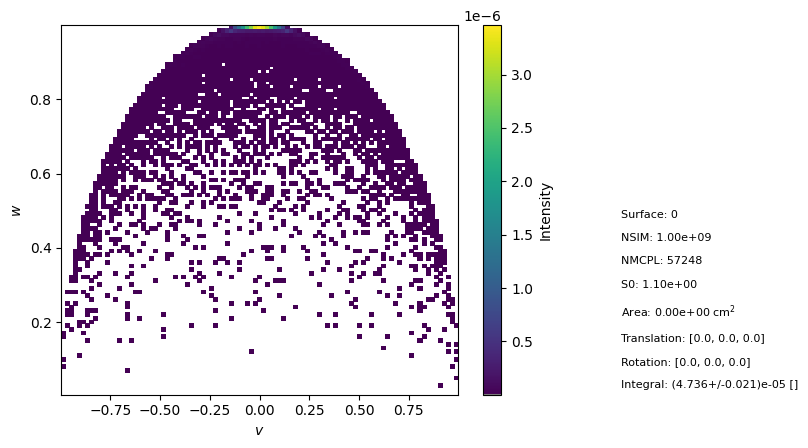

In [18]:
plano_w.plot_distribution(vars=['v','w'],bins=[100,100], scales=['linear','linear'], norm_vars=[], info=True, zscale='linear',plot_difference=False,Difference_to=Plano_resampled_1)

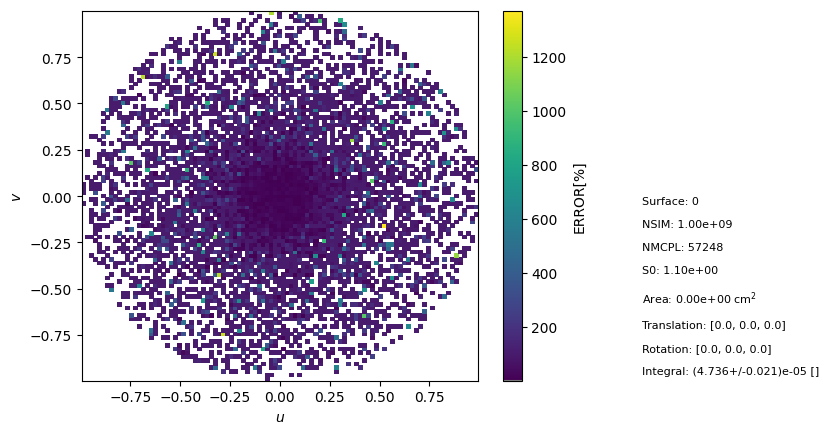

In [19]:
plano_w.plot_distribution(vars=['u','v'],bins=[100,100], scales=['linear','linear'], norm_vars=[], info=True, zscale='linear',plot_difference=True,Difference_to=Plano_resampled_1)

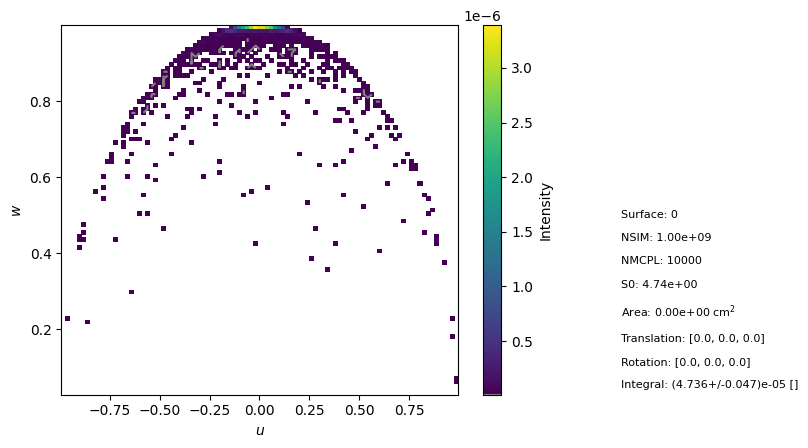

In [20]:
Plano_resampled_1.plot_distribution(vars=['u','w'],bins=[100,100], scales=['linear','linear'], norm_vars=[], info=True, zscale='linear',plot_difference=False)

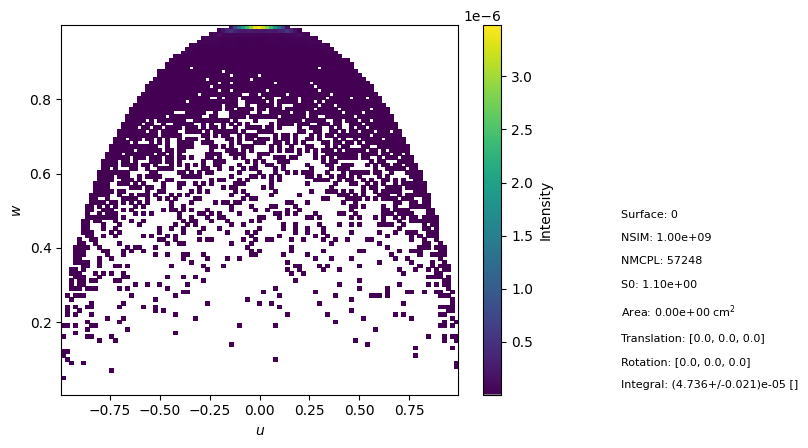

In [21]:
plano_w.plot_distribution(vars=['u','w'],bins=[100,100], scales=['linear','linear'], norm_vars=[], info=True, zscale='linear',plot_difference=False)

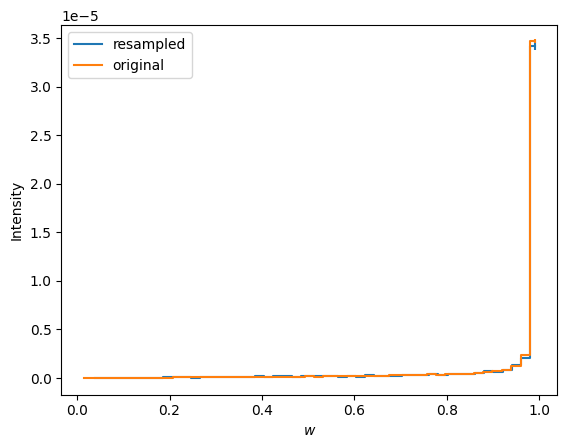

In [22]:
Plano_resampled_1.plot_distribution(vars=['w'],bins=[50], scales=['linear','linear'], norm_vars=[])
plano_w.plot_distribution(vars=['w'],bins=[50], scales=['linear','linear'], norm_vars=[])


plt.gca().lines[0].set_label('resampled')
plt.gca().lines[1].set_label('original')
plt.legend()

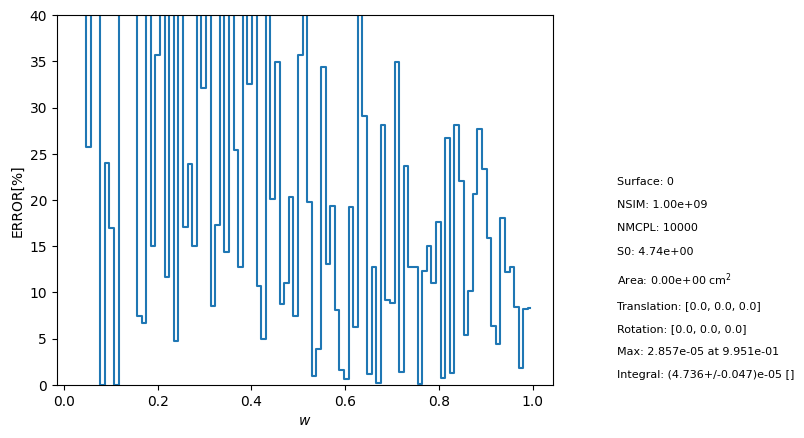

In [23]:
Plano_resampled_1.plot_distribution(vars=['w'],bins=[100], scales=['linear','linear'], norm_vars=[], info=True,plot_difference=True,Difference_to=Plano_1)
plt.ylim(0,40)
plt.show()

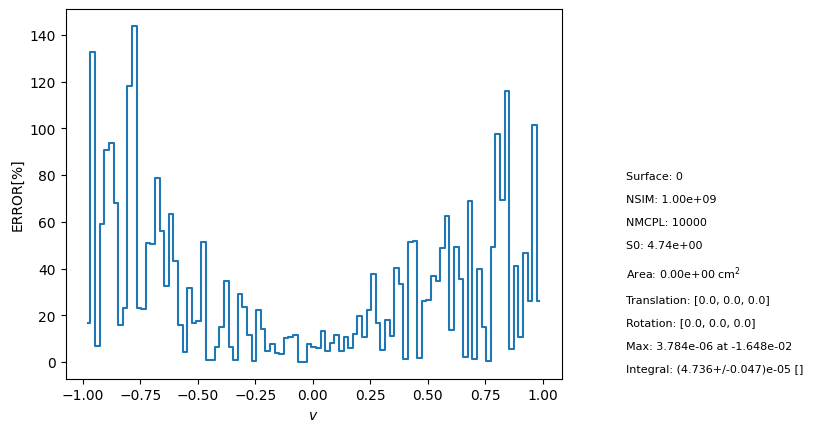

In [24]:
Plano_resampled_1.plot_distribution(vars=['v'],bins=[100], scales=['linear','linear'], norm_vars=[], info=True,plot_difference=True,Difference_to=Plano_1)

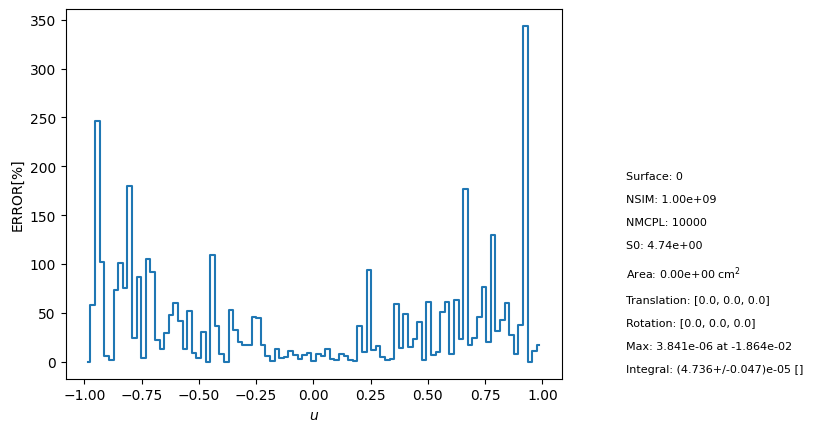

In [25]:
Plano_resampled_1.plot_distribution(vars=['u'],bins=[100], scales=['linear','linear'], norm_vars=[], info=True,plot_difference=True,Difference_to=Plano_1)

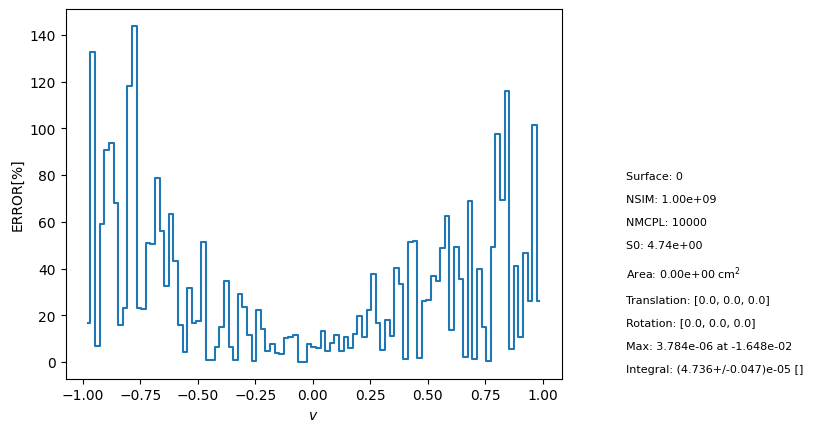

In [26]:
Plano_resampled_1.plot_distribution(vars=['v'],bins=[100], scales=['linear','linear'], norm_vars=[], info=True,plot_difference=True,Difference_to=Plano_1)

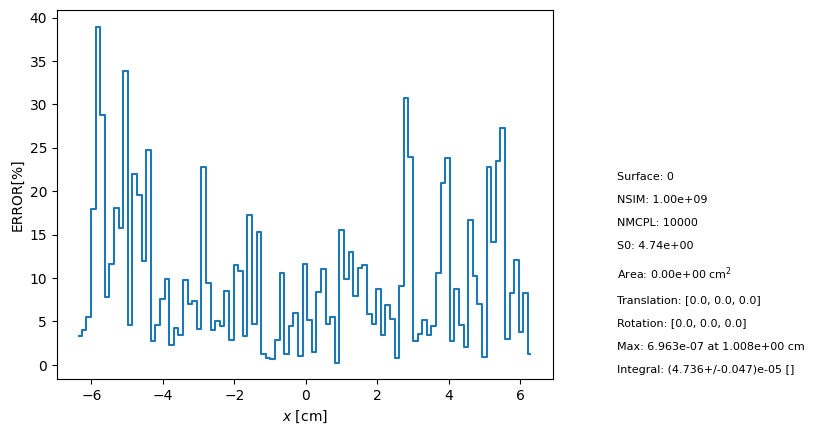

In [27]:
Plano_resampled_1.plot_distribution(vars=['x'],bins=[100], scales=['linear','linear'], norm_vars=[], info=True,plot_difference=True,Difference_to=Plano_1)

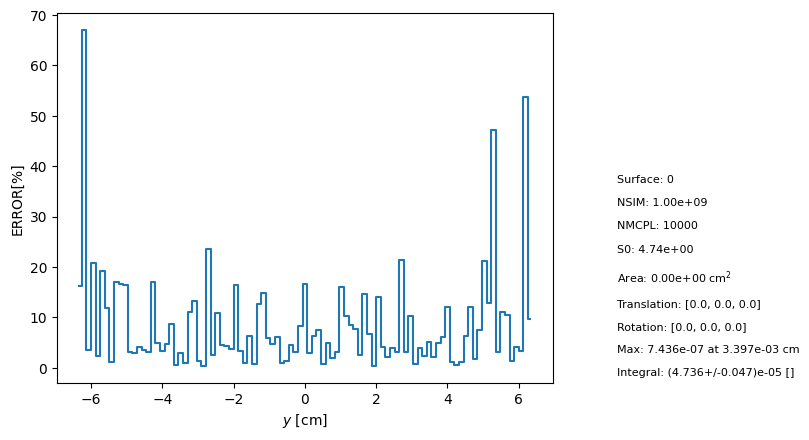

In [28]:
Plano_resampled_1.plot_distribution(vars=['y'],bins=[100], scales=['linear','linear'], norm_vars=[], info=True,plot_difference=True,Difference_to=Plano_1)

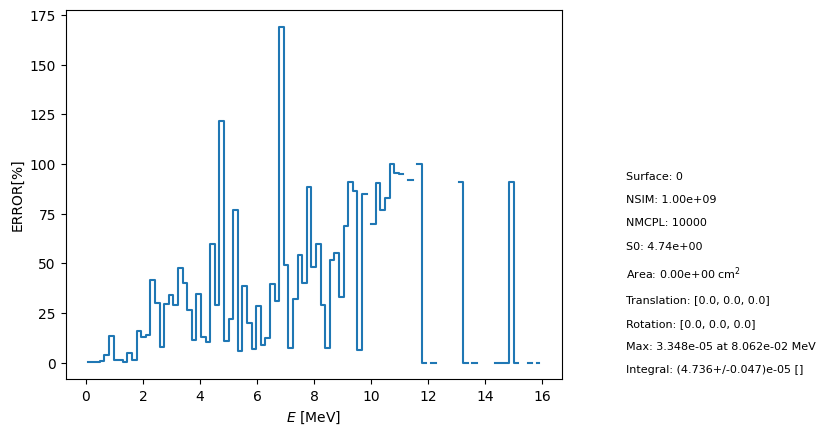

In [29]:
Plano_resampled_1.plot_distribution(vars=['E'],bins=[100], scales=['linear','linear'], norm_vars=[], info=True,plot_difference=True,Difference_to=Plano_1)

Plotting x*f(x) instead of f(x) (xscale='log')


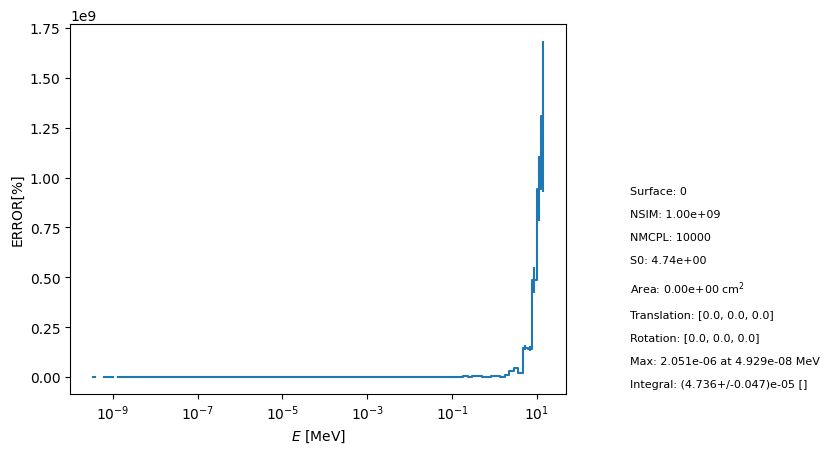

In [30]:
Plano_resampled_1.plot_distribution(vars=['E'],bins=[100], scales=['log','linear'], norm_vars=[], info=True,plot_difference=True,Difference_to=Plano_1)


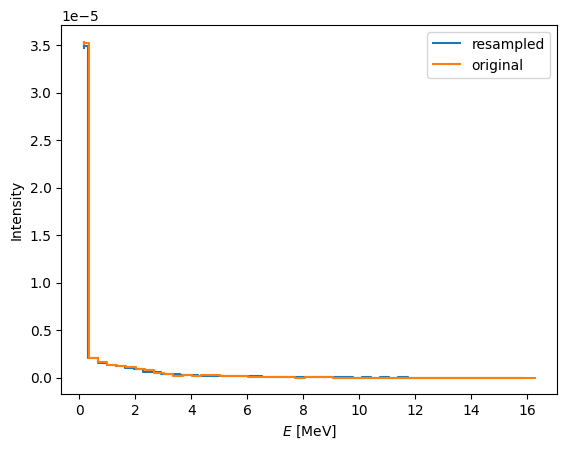

In [31]:
Plano_resampled_1.plot_distribution(vars=['E'],bins=[50], scales=['linear','linear'], norm_vars=[])
Plano_1.plot_distribution(vars=['E'],bins=[50], scales=['linear','linear'], norm_vars=[])


plt.gca().lines[0].set_label('resampled')
plt.gca().lines[1].set_label('original')
plt.legend()